In [295]:
import numpy as np
import sys
sys.path.insert(0, '../..') #This line adds '../..' to the path so we can import the net_framework python file
from RNN_model_GRAD import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
try:
    import ujson as json
except ImportError:
    import json
import scipy.linalg as slin
from mpl_toolkits.mplot3d import Axes3D

## Loading Trained Weights

Having trained the network weights on the remote computer, and loading the weights

In [296]:
with open('256_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [297]:
weight_history.keys()

dict_keys(['input1 weights', 'connectivity matrix', 'trained weights', 'bias', 'output weights', 'noise weights', 'input2 weights'])

Defining weights of the network. Final trained weights are in final_weights

In [298]:
noise_weights = np.array(weight_history['noise weights'])
bias_weights = np.array(weight_history['bias'])
input1_weights = np.array(weight_history['input1 weights'])
input2_weights = np.array(weight_history['input2 weights'])
output_weight_matrix = np.array(weight_history['output weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
final_weights = np.array(weight_history['trained weights'][-1])

## Defining Network

In [299]:
num_nodes = 256
time_constant = 100 #ms
timestep = 10 #ms
noise_strength = 0.01

weight_matrix = tf.Variable(final_weights)
connectivity_matrix = tf.constant(connectivity_matrix)

input_weight_matrix = tf.constant(np.vstack((bias_weights, noise_weights, input1_weights, input2_weights)))

def input1(time):
    #No input for now
    return 0
 
def input2(time):
    #No input for now
    return 0
def bias(time):
    return 1
def noise(time):
    return np.sqrt(2 * time_constant/timestep) * noise_strength * np.random.normal(0, 1)


input_funcs = [bias, noise, input1, input2]

init_activations = tf.constant(np.zeros((num_nodes, 1)))
output_weight_matrix = tf.constant(output_weight_matrix)
        
network = RNN(weight_matrix, connectivity_matrix, init_activations, output_weight_matrix, time_constant = time_constant,
             timestep = timestep,activation_func = keras.activations.relu, output_nonlinearity = lambda x : x)

## Simulating Network Output Without Input

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1480.32it/s]


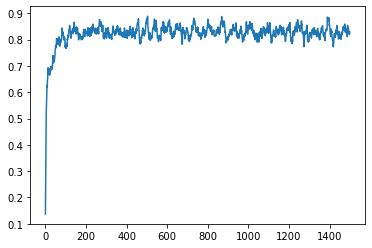

In [300]:
time = 15000 #ms
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)

outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.show()

## Testing Network

Now, simulating network activity to ensure that it works.

In [301]:
network.reset_activations()
switch_time = int(np.random.normal(time/2, time/10))

val1 = 0.2
val2 = 1.3
val3 = 1.5
val4 = 1.2

def input1(time):
    #running for 15 seconds = 15000ms
    if time < switch_time:
        return val1 + np.random.normal(0, .01)
    else:
        return val3 + np.random.normal(0, .01)

def input2(time):
    #running for 15 seconds = 15000ms
    if time < switch_time:
        return val2 + np.random.normal(0, .01)
    else:
        return val4 + np.random.normal(0, .01)

def target_func(time):
    #running for 15 seconds = 15000ms
    if time < switch_time:
        return 0.5 * (val1 > val2) + .8 * (val2 > val1)
    else:
        return 0.5 * (val3 > val4) + .8 * (val4 > val3)
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1492.07it/s]


0.2 1.3 1.5 1.2


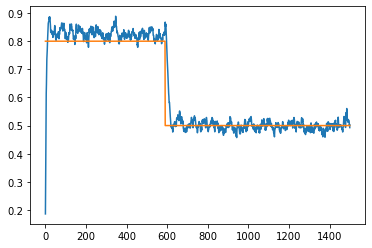

In [302]:
print(val1,val2,val3,val4)

outputs = tf.transpose(outputs).numpy()[0]
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [303]:
activations = [activation.numpy() for activation in activations]
activations = np.asarray(activations)

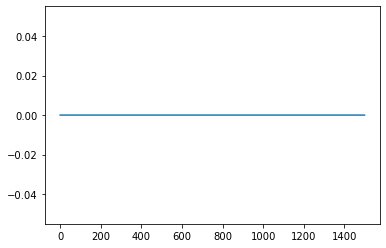

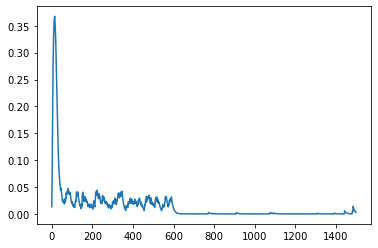

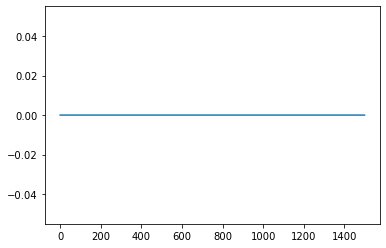

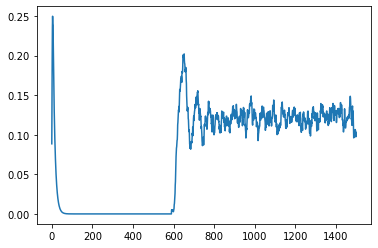

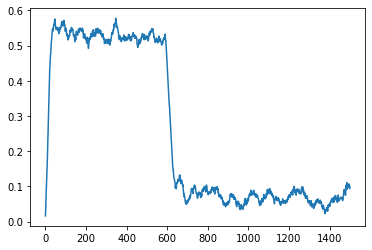

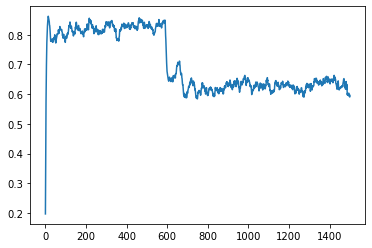

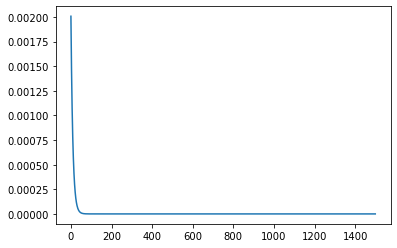

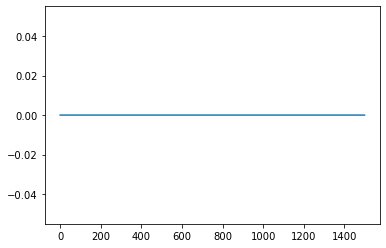

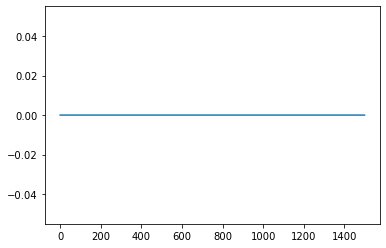

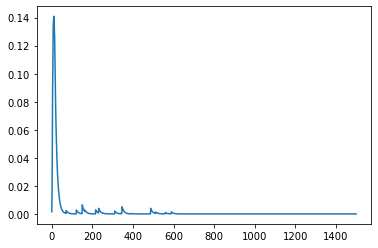

In [304]:
for i in range(10):
    fig, ax = plt.subplots()
    plt.plot(range(len(activations[:,i])), activations[:,i])
    plt.show()

In [11]:
net_weight_history = weight_history['trained weights']

In [12]:
print(len(net_weight_history))

100


## Principal Values of Weight Matrix

Plotting change in singular values over training iteration

In [13]:
num_singular_values = 25
values = []
variance_prop = []
for mat in tqdm(net_weight_history):
    u, s, vh = np.linalg.svd(mat)
    values.append(s[:num_singular_values])
    tot_variance = np.dot(s,s)
    variance_prop.append([val**2/tot_variance for val in s])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.60it/s]


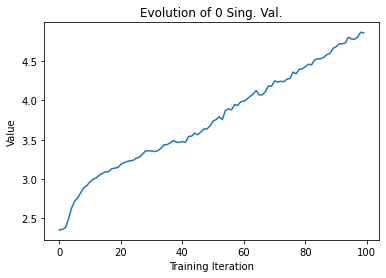

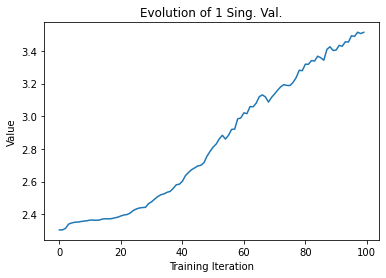

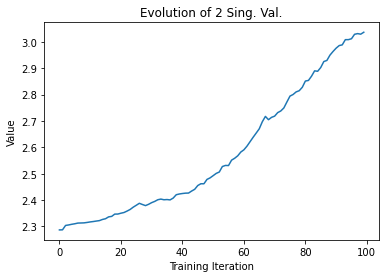

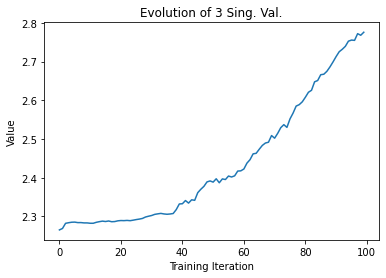

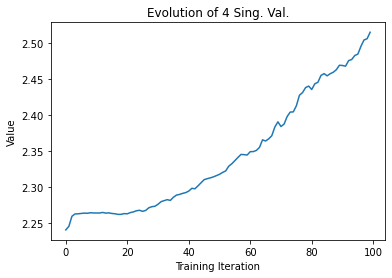

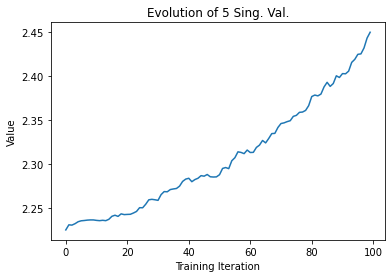

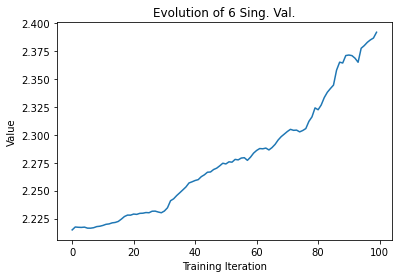

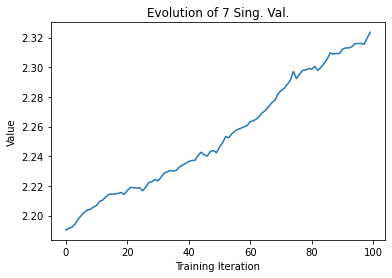

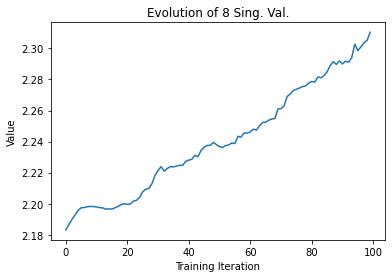

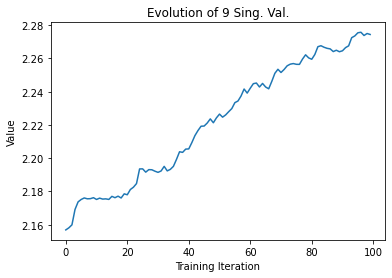

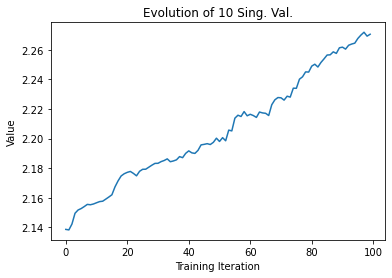

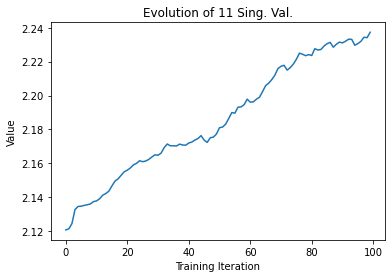

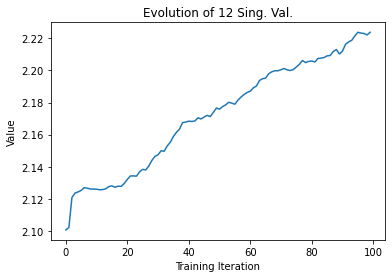

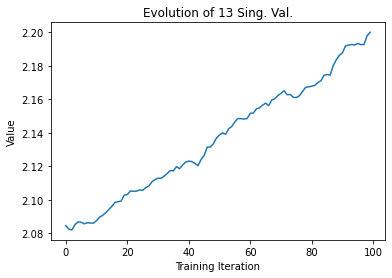

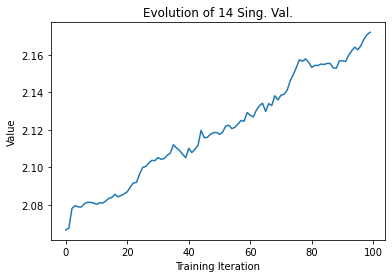

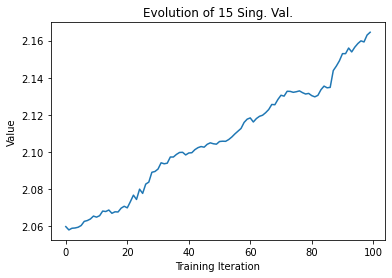

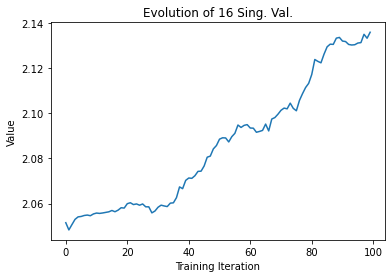

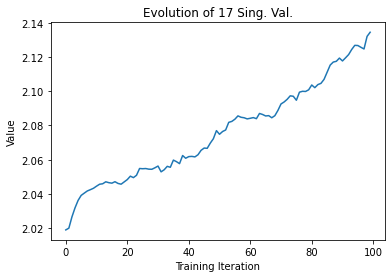

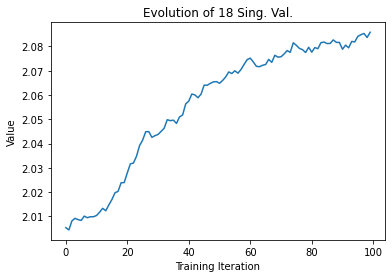

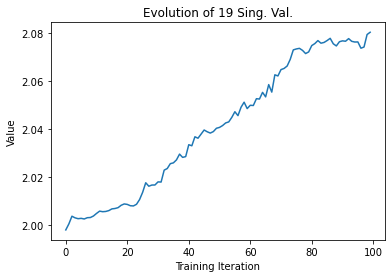

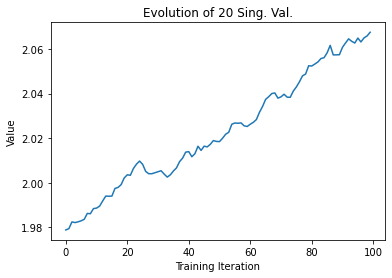

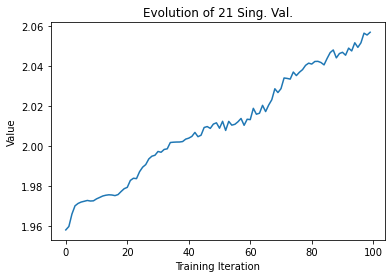

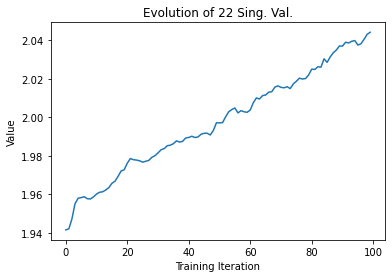

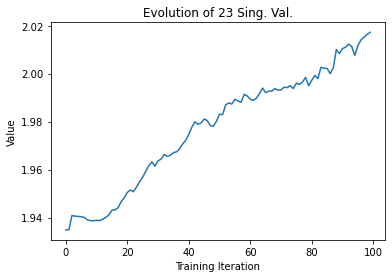

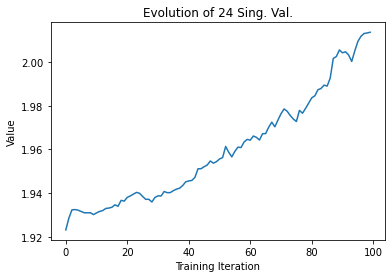

In [14]:
#The i'th column is the evolution of the i'th singular value
values = np.asarray(values)
num_total_iters = values[:, 0].shape[0]

for i in range(num_singular_values):
    fig, ax = plt.subplots()
    plt.plot(range(num_total_iters), values[:, i])
    plt.title('Evolution of ' + str(i) + ' Sing. Val.')
    plt.xlabel('Training Iteration')
    plt.ylabel('Value')
    plt.show()


Plotting percent variance captured in singular values over training iteration

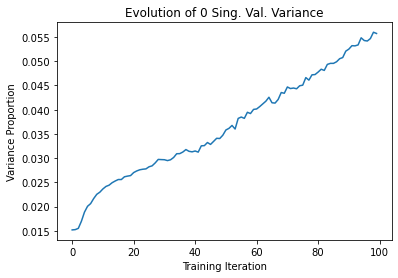

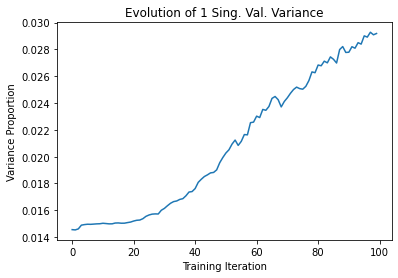

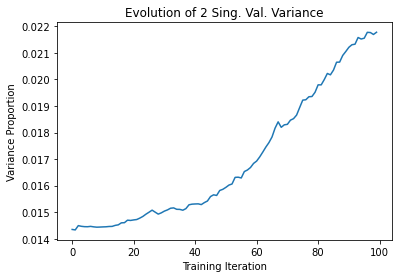

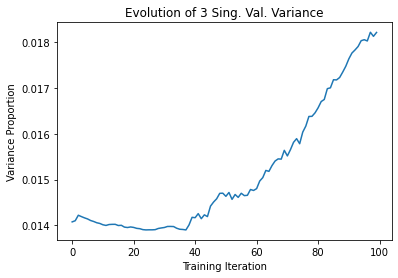

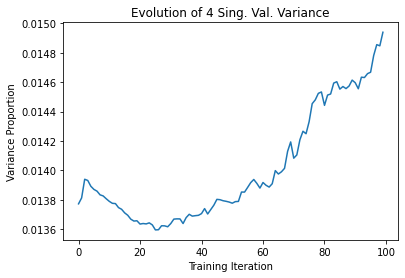

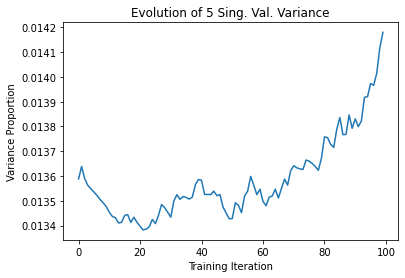

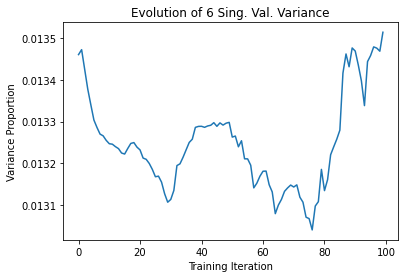

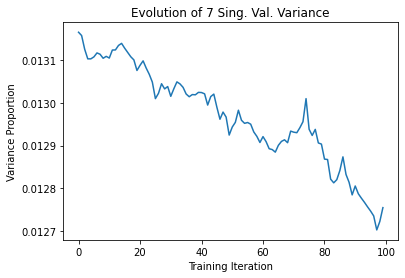

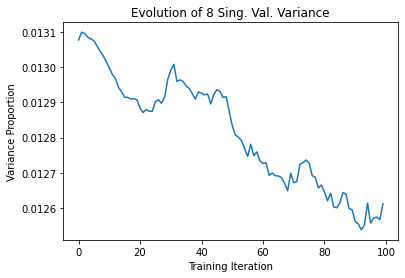

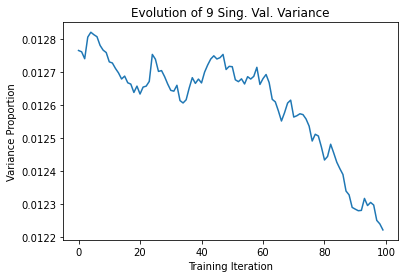

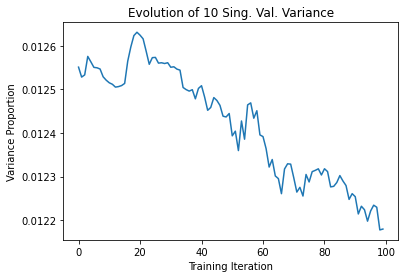

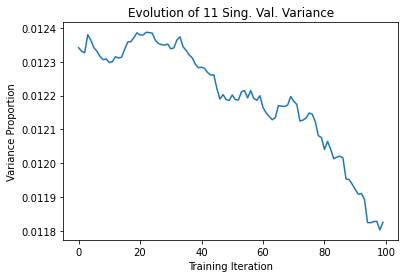

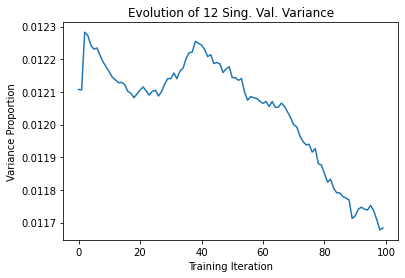

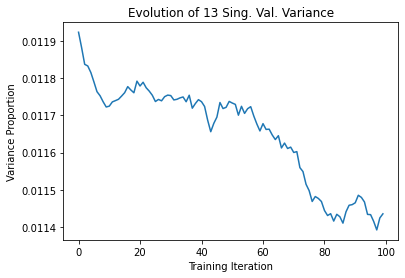

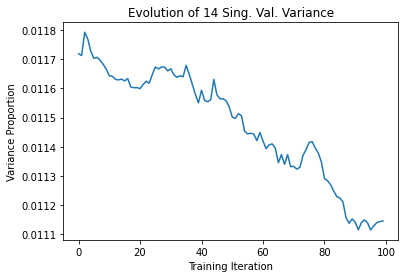

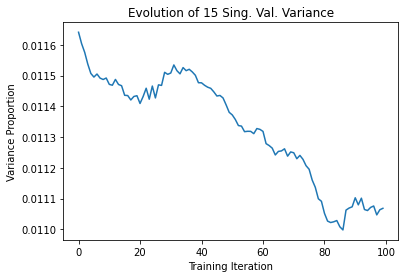

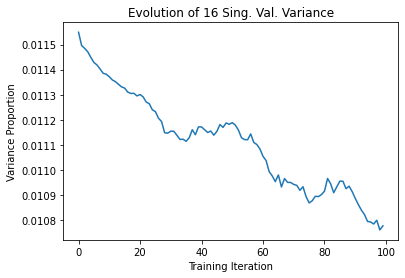

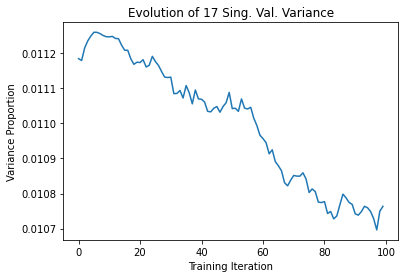

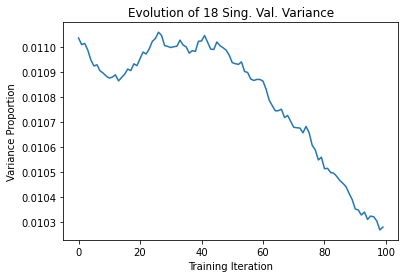

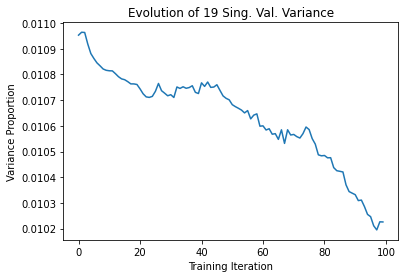

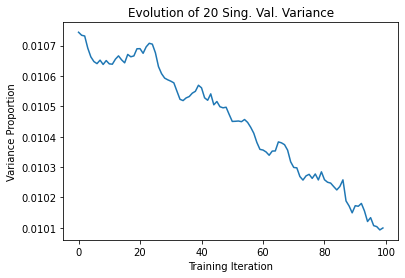

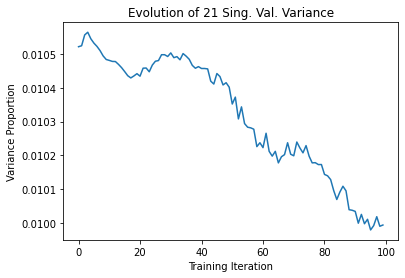

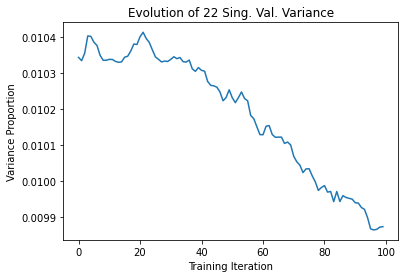

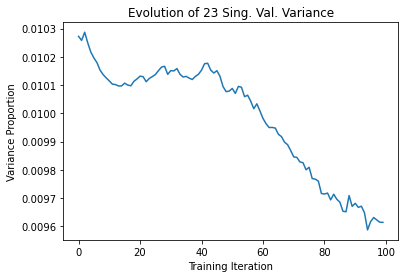

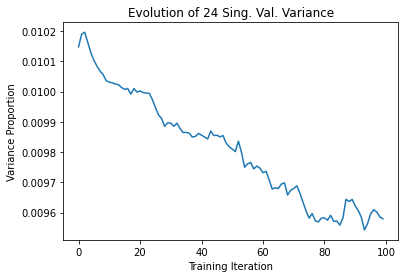

In [15]:
variance_prop = np.asarray(variance_prop)
for i in range(num_singular_values):
    fig, ax = plt.subplots()
    plt.plot(range(num_total_iters), variance_prop[:, i])
    plt.title('Evolution of ' + str(i) + ' Sing. Val. Variance')
    plt.xlabel('Training Iteration')
    plt.ylabel('Variance Proportion')
    plt.show()

## Schur Decomp.

Plotting sum of squares of off-diagonal components in schur decomposition of the matrices over training iteration

In [16]:
values = []
for mat in tqdm(net_weight_history):
    T, Z = slin.schur(mat)
    values.append(np.linalg.norm(T))
values = np.asarray(values)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.56it/s]


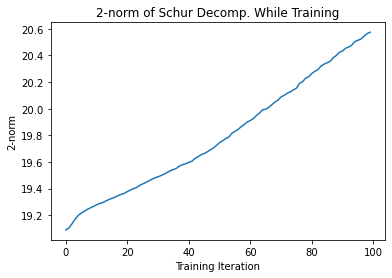

In [17]:
fig, ax = plt.subplots()
plt.plot(range(num_total_iters), values)
plt.xlabel('Training Iteration')
plt.ylabel('2-norm')
plt.title('2-norm of Schur Decomp. While Training')
plt.show()

## Looking at Weight Matrix

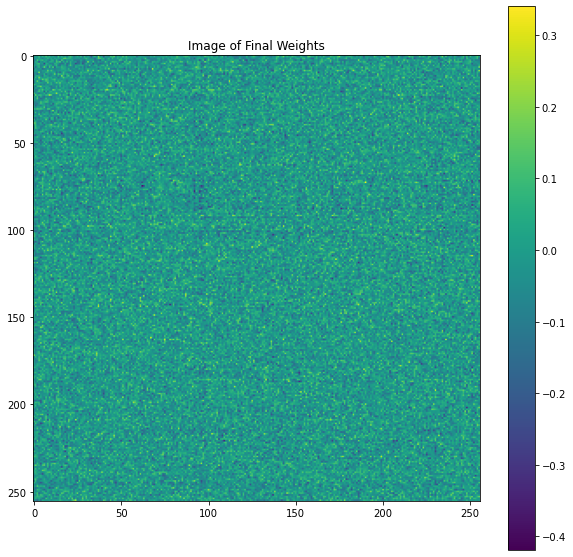

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(final_weights)
plt.title('Image of Final Weights')
plt.colorbar()

In [19]:
np.mean(final_weights)

-0.008944996034621483

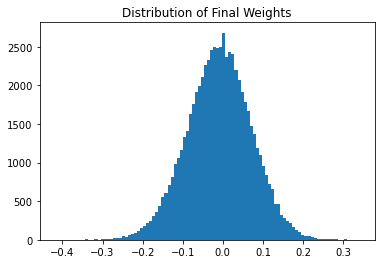

In [20]:
flattened = final_weights.flatten()
plt.hist(flattened, bins = 100)
plt.title('Distribution of Final Weights')
plt.show()

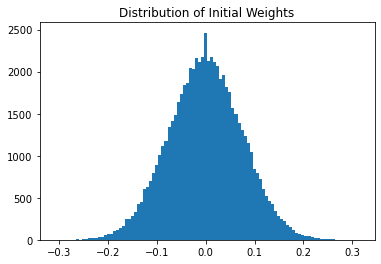

In [21]:
init = np.array(weight_history['trained weights'][0])
flattened = init.flatten()
plt.hist(flattened, bins = 100)
plt.title('Distribution of Initial Weights')
plt.show()

## Eigenvalues

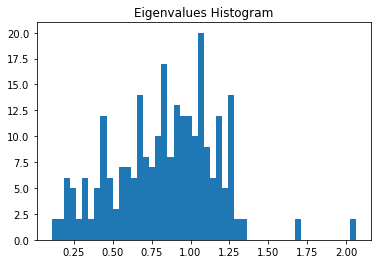

In [22]:
eig = np.linalg.eigvals(final_weights)
plt.hist(np.abs(eig), bins = 50)
plt.title('Eigenvalues Histogram')
plt.show()

## White Noise Input

In [23]:
#White noise input

time = 10000
network.reset_activations()
def rule_input(time):
    #running for 5 seconds = 5000ms
    return np.random.normal(0, 1)

input_funcs[2] = rule_input
inputs = network.convert(time, input_funcs)
outputs, activations = network.simulate(time, inputs, input_weight_matrix)


outputs = tf.transpose(outputs).numpy()[0]

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 436.96it/s]


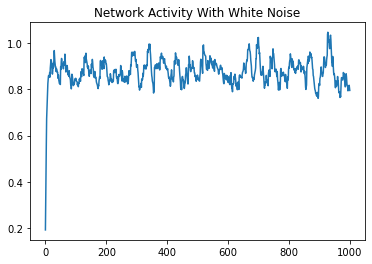

In [24]:
fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.title('Network Activity With White Noise')
plt.show()

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mat', 'time', 'eig', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


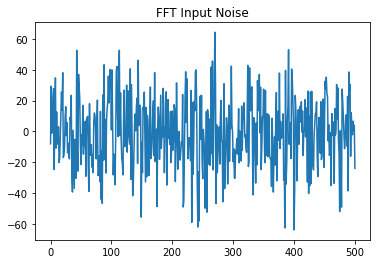

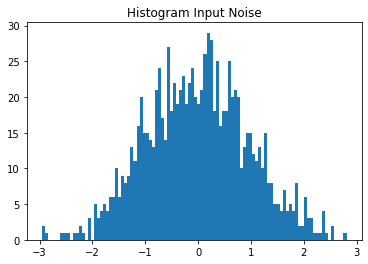

In [25]:
#Frequency space for Gaussian Noise
%pylab inline
fig1, ax1 = plt.subplots(1,1)
plt.plot(range(int(len(inputs[:, 2])/2) + 1), np.fft.rfft(inputs[:, 2]))
plt.title('FFT Input Noise')
fig1.show()

fig3, ax3 = plt.subplots(1,1)
plt.hist(np.asarray(inputs[:, 2]), bins = 100)
plt.title('Histogram Input Noise')
fig3.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


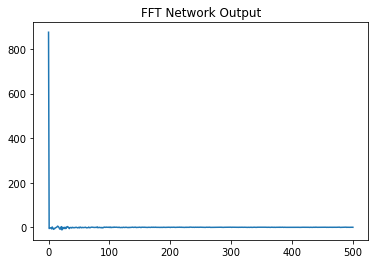

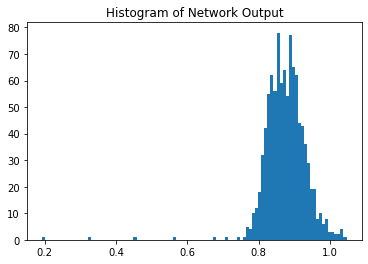

In [26]:
plt.plot(range(int(len(outputs)/2) + 1), np.fft.rfft(outputs))
plt.title('FFT Network Output')
plt.show()


plt.hist(outputs, bins = 100)
plt.title('Histogram of Network Output')
plt.show()

## Difference Between Values vs. Percentage Correct at Diff. Locations

Only run the next few cells once - it takes a while. After running once, the results will be saved into a json file

In [305]:
net_percent_correct={}

**input2>input1**

In [ ]:
locations = np.arange(0.25, 2, 0.25)
differences = np.arange(0, 0.25, 0.01)
num_trials = 25
time = 10000
percent_correct = {}
for location in locations:
    correct_per_diff = []
    std_correct_per_diff=[]
    for diff in tqdm(differences, leave = True, position = 0):
        num_correct = []
        for trial in range(num_trials):
            network.reset_activations()
            val1 = location
            val2 = val1 + diff
            def input1(time):
                    return val1 + np.random.normal(0, .01)
            def input2(time):
                    return val2 + np.random.normal(0, .01)

            input_funcs[2] = input1
            input_funcs[3] = input2
            inputs = network.convert(time, input_funcs)
            outputs, activations = network.simulate(time, inputs, input_weight_matrix, disable_progress_bar = True)
            outputs = tf.transpose(outputs).numpy()[0]
            out = np.mean(outputs[100:])
            target = 0.5 * (val1 > val2) + .8 * (val2 > val1)
            #not_target = 0.8 * (val1 > val2) + .5 * (val2 > val1)
            error=np.abs(out-target)/.3
            correct = 1 - error
            num_correct.append(correct)
        correct_per_diff.append(np.mean(num_correct))
        std_correct_per_diff.append(np.std(num_correct))
    percent_correct[location] = {}
    percent_correct[location]['vals']=correct_per_diff
    percent_correct[location]['stds']=std_correct_per_diff

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [06:58<00:18, 18.28s/it]

Skip this cell as well

In [ ]:
net_percent_correct['input2>input1']=percent_correct

**input1>input2**

In [ ]:
locations = np.arange(0.25, 2, 0.25)
differences = np.arange(0, 0.25, 0.01)
num_trials = 25
time = 10000
percent_correct = {}
for location in locations:
    correct_per_diff = []
    std_correct_per_diff=[]
    for diff in tqdm(differences, leave = True, position = 0):
        num_correct = []
        for trial in range(num_trials):
            network.reset_activations()
            val1 = location
            val2 = val1 - diff

            def input1(time):
                    return val1 + np.random.normal(0, .01)
            def input2(time):
                    return val2 + np.random.normal(0, .01)

            input_funcs[2] = input1
            input_funcs[3] = input2
            inputs = network.convert(time, input_funcs)
            outputs, activations = network.simulate(time, inputs, input_weight_matrix, disable_progress_bar = True)
            outputs = tf.transpose(outputs).numpy()[0]
            out = np.mean(outputs[100:])
            target = 0.5 * (val1 > val2) + .8 * (val2 > val1)
            #not_target = 0.8 * (val1 > val2) + .5 * (val2 > val1)
            error=np.abs(out-target)/(.8-.5)
            correct = 1 - error
            num_correct.append(correct)
        correct_per_diff.append(np.mean(num_correct))
        std_correct_per_diff.append(np.std(num_correct))
    percent_correct[location] = {}
    percent_correct[location]['vals']=correct_per_diff
    percent_correct[location]['stds']=std_correct_per_diff

In [ ]:
net_percent_correct['input1>input2']=percent_correct

In [ ]:
with open('percentages_correct.json', 'w') as f:
    json.dump(net_percent_correct, f)

**input2>input1 Plots**

In [ ]:
with open('percentages_correct.json') as f:
    percent_correct = json.load(f)['input2>input1']
locations = np.arange(0.25, 2, 0.25)
differences = np.arange(0, 0.25, 0.01)

for location in locations:
    fig, ax = plt.subplots(1,1)
    plt.errorbar(differences, percent_correct[str(location)]['vals'],yerr=percent_correct[str(location)]['stds'], fmt='ro:')
    plt.title('Percent Correct vs Difference at ' + str(location))
    plt.xlabel('Difference')
    plt.ylabel('Correct (%)')

Plot when accuracy > threshold for each location. 

In [ ]:
threshold = 75
greater_than_threshold = []
for location in locations:
    correct = percent_correct[str(location)]['vals']
    idx=25
    for i, val in enumerate(correct):
        if val >=threshold:
            idx=i
            break
    greater_than_threshold.append(idx)
plotting_diff = np.append(differences, .5)
plt.plot(locations, [plotting_diff[g] for g in greater_than_threshold], 'bo:')
plt.title('When Accuracy Crosses Threshold=' + str(threshold) + '%')
plt.ylim(0,0.3)
plt.xlabel('Location')
plt.ylabel('Difference')

## DCA Trajectories

This part requires installation of Dynamical Components Analysis from the BouchardLab GitHub

In [32]:
from dca.dca import DynamicalComponentsAnalysis as DCA
from sklearn.linear_model import Ridge as RR
from sklearn.metrics import r2_score
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA

1. Defining X matrix using dynamics of each node in the network (each row is a different timestep)
2. Then running DCA on this network activity to get a low-dimensional subspace.
3. Then fitting data to output using linear regression (no intercept) - plot r^2 score for fit.

In [46]:
network.reset_activations()
time=10000
switch_time=[2500, 7500]

val1 = 0.2
val2 = 1.3
val3 = 1.5
val4 = 1.2

def input1(time):
    if time < switch_time[0]:
        return val1 + np.random.normal(0, .01)
    elif time >= switch_time[0] and time < switch_time[1]:
        return val3 + np.random.normal(0, .01)
    else:
        return val1 + np.random.normal(0, .01)
def input2(time):
    if time < switch_time[0]:
        return val2 + np.random.normal(0, .01)
    elif time >= switch_time[0] and time < switch_time[1]:
        return val4 + np.random.normal(0, .01)
    else:
        return val2 + np.random.normal(0, .01)

def target_func(time):
    #running for 15 seconds = 15000ms
    if time < switch_time[0]:
        return 0.5 * (val1 > val2) + .8 * (val2 > val1)
    elif time>= switch_time[0] and time < switch_time[1]:
        return 0.5 * (val3 > val4) + .8 * (val4 > val3)
    else:
        return 0.5 * (val1 > val2) + .8 * (val2 > val1)
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 657.46it/s]


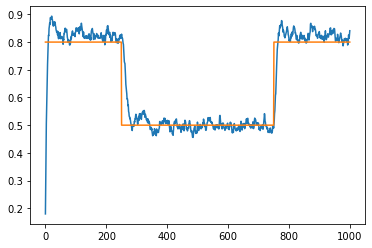

In [47]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [48]:
activations = [activation.numpy() for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [49]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [50]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [51]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

In [52]:
subspaces = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces.append(Xd)

1
2
3
4
5
6
7
8
9
10


Text(0, 0.5, '0-1 normalized metric')

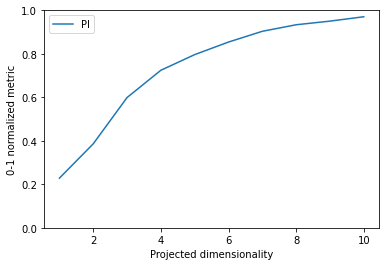

In [53]:
plt.plot(ds, np.asarray(pi)/max_pi.numpy(), label='PI')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Plotting 1D Projection')

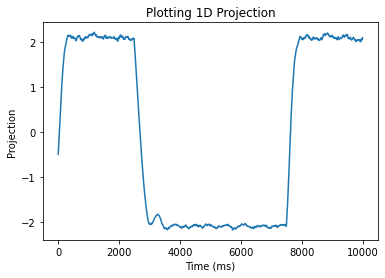

In [58]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Projection')
plt.title('Plotting 1D Projection')

Subspace angles for each projection (1D - 10D)

Plotting scatter of all subspace angles for each pair

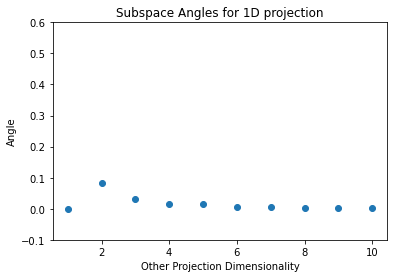

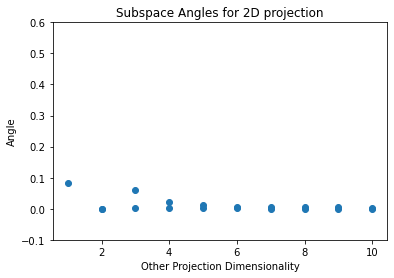

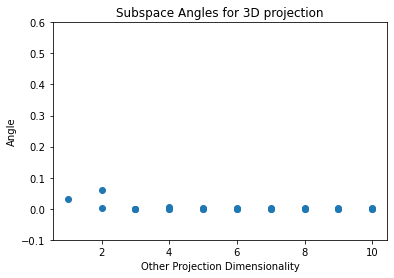

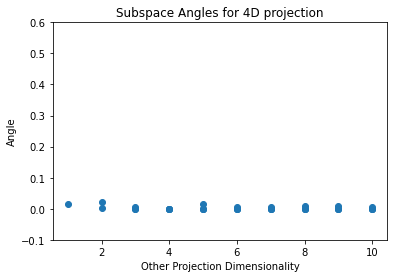

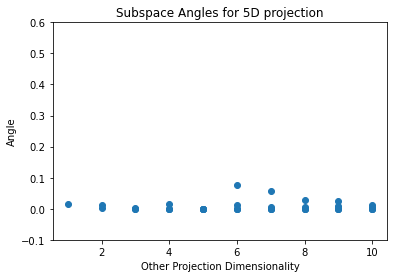

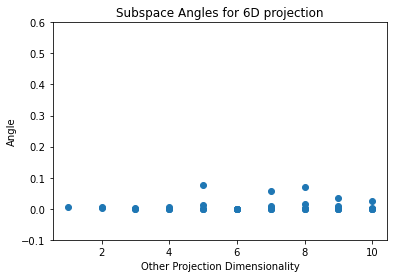

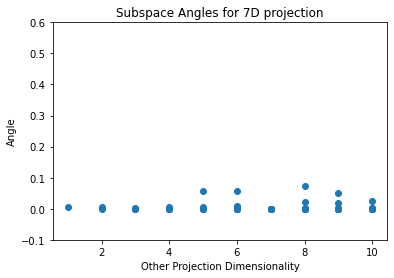

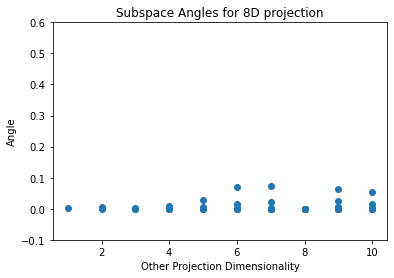

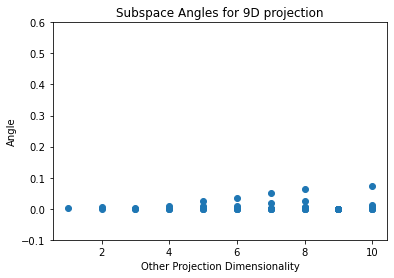

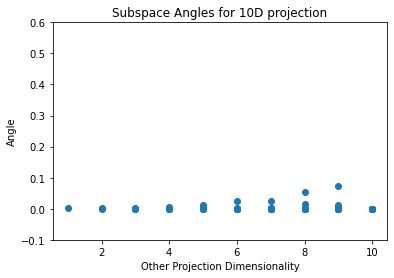

In [59]:
for d in ds:
    x = []
    y = []
    for tmpDim in ds:
        angls = subspace_angles(subspaces[d-1], subspaces[tmpDim - 1])
        x = np.append(x, tmpDim * np.ones(angls.size))
        y = np.append(y, angls)
    fig, ax = plt.subplots(1,1)
    ax.set_title('Subspace Angles for ' + str(d) + 'D projection')
    ax.set_xlabel('Other Projection Dimensionality')
    ax.set_ylabel('Angle')
    ax.scatter(x, y)
    plt.ylim(-0.1, 0.6)
    plt.show()

Subspaces are nested

Plot of DCA1 vs DCA2 for 2D projection

Accounts for 0.38621193295206663 of the predictive information


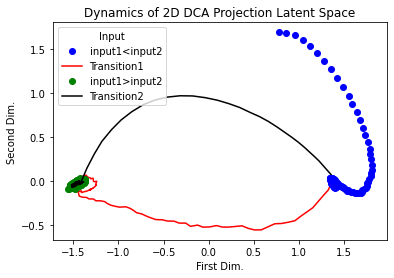

In [60]:
print('Accounts for ' + str((np.asarray(pi)/max_pi.numpy())[1]) + ' of the predictive information')
transition_times = [0, 250, 750, 1000]
change = 100

t = [transition_times[0],transition_times[1] - change , transition_times[1] + change
     , transition_times[2] - change, transition_times[2] + change, transition_times[3]]
plt.plot(subspaces[1][t[0]:t[1], 0], subspaces[1][t[0]:t[1], 1], 'bo', label = 'input1<input2')
plt.plot(subspaces[1][t[1]:t[2], 0], subspaces[1][t[1]:t[2], 1], 'r-', label = 'Transition1')
plt.plot(subspaces[1][t[2]:t[3], 0], subspaces[1][t[2]:t[3], 1], 'go', label = 'input1>input2')
plt.plot(subspaces[1][t[3]:t[4], 0], subspaces[1][t[3]:t[4], 1], 'k-', label = 'Transition2')
plt.plot(subspaces[1][t[4]:t[5], 0], subspaces[1][t[4]:t[5], 1], 'bo') #input1<input2

plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')
plt.legend(title = 'Input')

Projecting dynamics onto 3D subspace

Text(0.5, 0, 'Third Dim.')

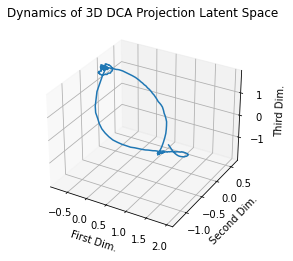

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(subspaces[2][:, 0], subspaces[2][:, 1], zs=subspaces[2][:, 2])

plt.title('Dynamics of 3D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')
ax.set_zlabel('Third Dim.')
#plt.legend(title = 'Input')

Plotting Network output using same time intervals and legend as above

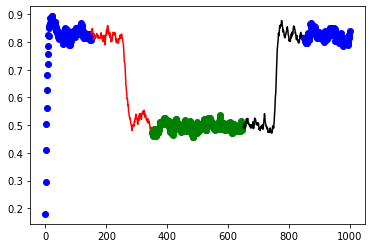

In [62]:
fig, ax = plt.subplots()
plt.plot(range(len(outputs))[t[0]:t[1]], outputs[t[0]:t[1]], 'bo')
plt.plot(range(len(outputs))[t[1]:t[2]], outputs[t[1]:t[2]], 'r-')
plt.plot(range(len(outputs))[t[2]:t[3]], outputs[t[2]:t[3]], 'go')
plt.plot(range(len(outputs))[t[3]:t[4]], outputs[t[3]:t[4]], 'k-')
plt.plot(range(len(outputs))[t[4]:t[5]], outputs[t[4]:t[5]], 'bo')
plt.show()

Observations: Trajectory transitions between two stationary states in latent space. The latent space projection shows the transition start prior to the network output changing. The latent space and output transition trajectory has little noise and the noise is only seen when the network is in its steady-state

Plot of PCA1 vs PCA2 for Dynamics

In [63]:
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.93890953 0.02772334]


Text(0, 0.5, 'Second Dim.')

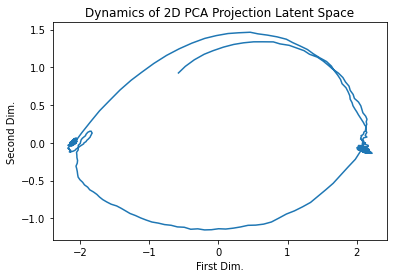

In [64]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

### Running DCA on the different attractors and comparing

**input1<input2**

In [65]:
network.reset_activations()
time=10000

val1 = 0.2
val2 = 1.3

def input1(time):
    return val1 + np.random.normal(0, .01)
def input2(time):
    return val2 + np.random.normal(0, .01)

def target_func(time):
    return 0.5 * (val1 > val2) + .8 * (val2 > val1)
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 694.33it/s]


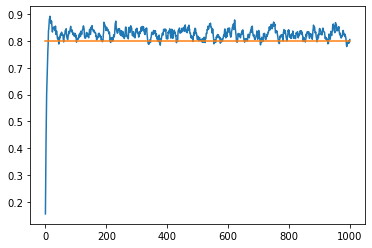

In [66]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [67]:
activations = [activation.numpy() for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [68]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [69]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [70]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction


In [71]:
subspaces_low_inp = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces_low_inp.append(Xd)

1
2
3
4
5
6
7
8


Text(0, 0.5, '0-1 normalized metric')

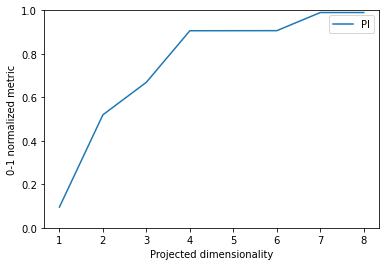

In [72]:
plt.plot(ds, np.asarray(pi)/max_pi.numpy(), label='PI')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Plotting 1D projection')

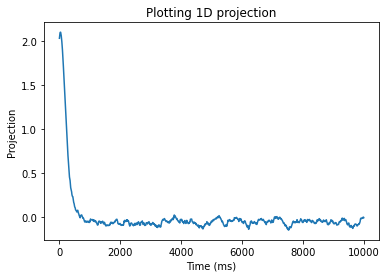

In [73]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Projection')
plt.title('Plotting 1D projection')

Plot of DCA1 vs DCA2 for 2D Projection

Text(0, 0.5, 'Second Dim.')

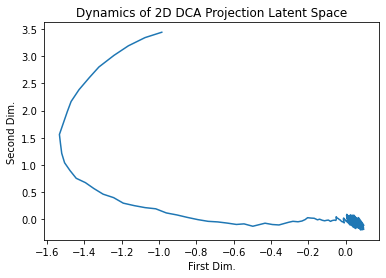

In [74]:
plt.plot(subspaces_low_inp[1][:, 0], subspaces_low_inp[1][:, 1])
plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

Plot of PCA1 vs PCA2 for Dynamics

In [75]:
X_low_inp = X
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.8256745  0.12350342]


Text(0, 0.5, 'Second Dim.')

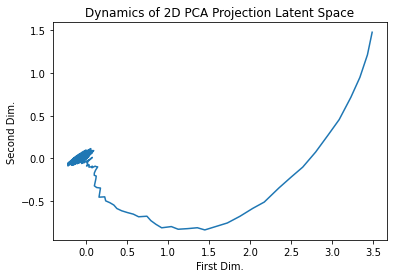

In [76]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

**Input1>Input2**

In [77]:
network.reset_activations()
time=10000

val1 = 1.5
val2 = 1.2

def input1(time):
    return val1 + np.random.normal(0, .01)
def input2(time):
    return val2 + np.random.normal(0, .01)

def target_func(time):
    return 0.5 * (val1 > val2) + .8 * (val2 > val1)
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 700.99it/s]


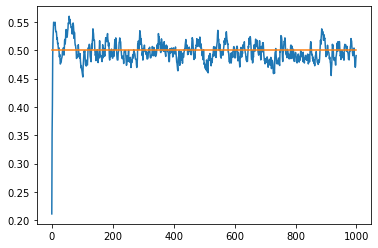

In [78]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [79]:
activations = [activation.numpy() for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [80]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [81]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [82]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

In [83]:
subspaces_high_inp = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces_high_inp.append(Xd)

1
2
3
4
5
6
7
8


Text(0, 0.5, '0-1 normalized metric')

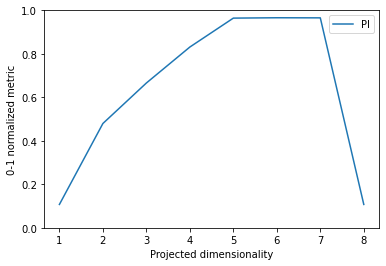

In [95]:
plt.plot(ds, np.asarray(pi)/max_pi.numpy(), label='PI')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Fitting 1D projection to Output')

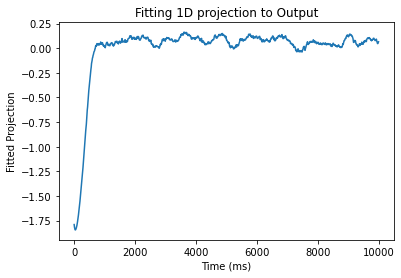

In [96]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Fitted Projection')
plt.title('Fitting 1D projection to Output')

Plot of DCA1 vs DCA2 of 2D Projection

Text(0, 0.5, 'Second Dim.')

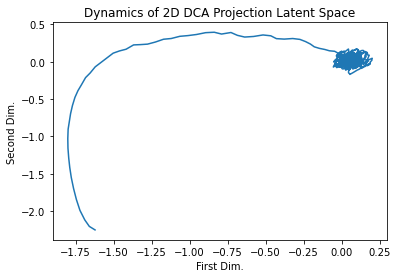

In [97]:
plt.plot(subspaces_high_inp[1][:, 0], subspaces_high_inp[1][:, 1])
plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

Plot of PCA1 vs PCA2 for Dynamics

In [98]:
X_high_inp = X
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.6741433  0.18207401]


Text(0, 0.5, 'Second Dim.')

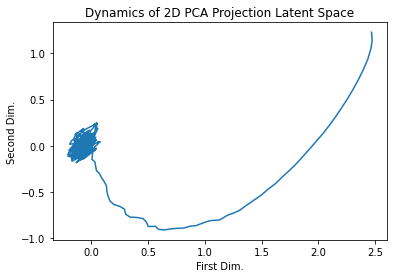

In [99]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

**Plotting Subspace Angles Between Low Input and High Input**

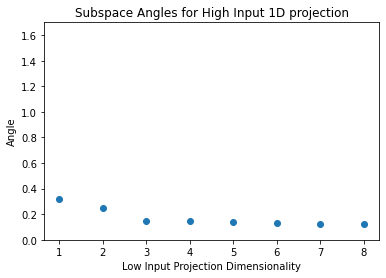

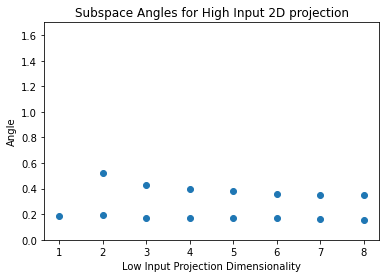

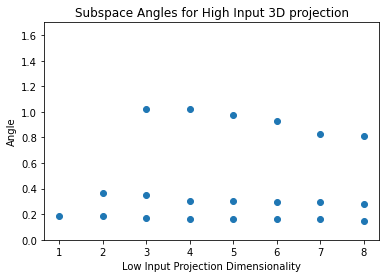

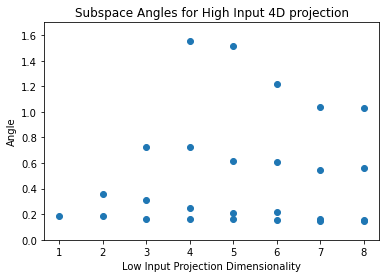

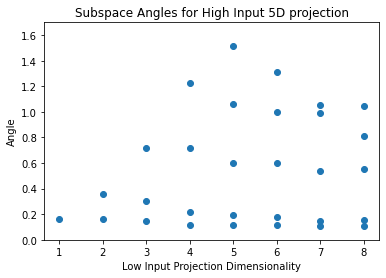

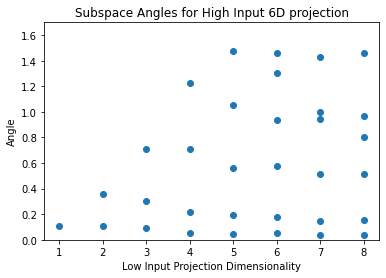

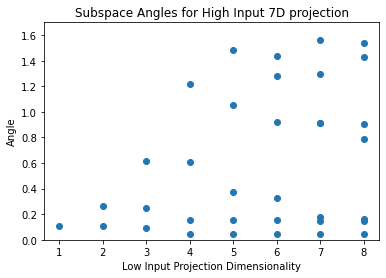

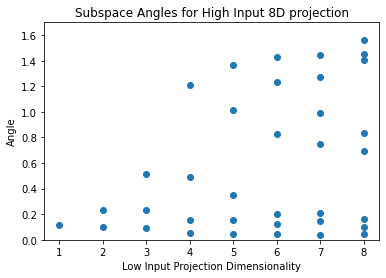

In [100]:
for d in ds:
    x = []
    y = []
    for tmpDim in ds:
        angls = subspace_angles(subspaces_high_inp[d-1], subspaces_low_inp[tmpDim - 1])
        x = np.append(x, tmpDim * np.ones(angls.size))
        y = np.append(y, angls)
    fig, ax = plt.subplots(1,1)
    ax.set_title('Subspace Angles for High Input ' + str(d) + 'D projection')
    ax.set_xlabel('Low Input Projection Dimensionality')
    ax.set_ylabel('Angle')
    ax.scatter(x, y)
    plt.ylim(0, 1.7)
    plt.show()

Plotting subspace angles for low and high input, same dimensionality

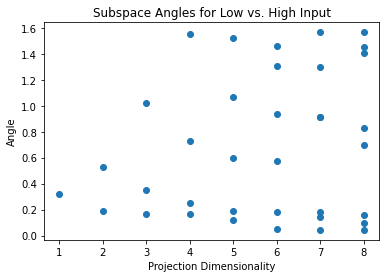

In [101]:
x = []
y = []
for d in ds:
    angls = subspace_angles(subspaces_high_inp[d-1], subspaces_low_inp[d - 1])
    x = np.append(x, d * np.ones(angls.size))
    y = np.append(y, angls)
fig, ax = plt.subplots(1,1)
ax.set_title('Subspace Angles for Low vs. High Input')
ax.set_xlabel('Projection Dimensionality')
ax.set_ylabel('Angle')
ax.scatter(x, y)
plt.show()

Orthogonal components begin to appear at 4D. The middle components begin to appear first at 2,3D. They kind of cluster at 8D.

Plot of 1D projections from each attractor against each other

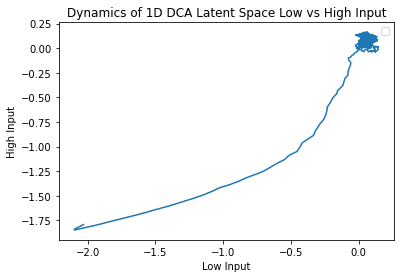

In [102]:
plt.plot(subspaces_low_inp[0][:, 0], subspaces_high_inp[0][:, 0])
plt.title('Dynamics of 1D DCA Latent Space Low vs High Input')
plt.xlabel('Low Input')
plt.ylabel('High Input')
plt.legend()

Plot of first PCA component of each attractor

In [103]:
pca_low = PCA(n_components=1)
pca_low.fit(X_low_inp)
print('The explained variance is:' + str(pca_low.explained_variance_ratio_))
X_pca_low = pca.transform(X_low_inp)

pca_high = PCA(n_components=1)
pca_high.fit(X_high_inp)
print('The explained variance is:' + str(pca_high.explained_variance_ratio_))
X_pca_high = pca.transform(X_high_inp)

The explained variance is:[0.8256748]
The explained variance is:[0.67414325]


Text(0, 0.5, 'High Input')

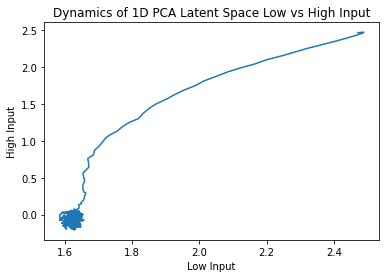

In [104]:
plt.plot(X_pca_low[:, 0], X_pca_high[:, 0])
plt.title('Dynamics of 1D PCA Latent Space Low vs High Input')
plt.xlabel('Low Input')
plt.ylabel('High Input')

PCA curves capture more noise. 

### Doing Same DCA Analysis for low-difference in diff. locations

In [134]:
network.reset_activations()
time=10000
switch_time=[2500, 7500]

val1 = 1.2
val2 = 1.3
val3 = 0.5
val4 = 0.4

def input1(time):
    if time < switch_time[0]:
        return val1 + np.random.normal(0, .01)
    elif time >= switch_time[0] and time < switch_time[1]:
        return val3 + np.random.normal(0, .01)
    else:
        return val1 + np.random.normal(0, .01)
def input2(time):
    if time < switch_time[0]:
        return val2 + np.random.normal(0, .01)
    elif time >= switch_time[0] and time < switch_time[1]:
        return val4 + np.random.normal(0, .01)
    else:
        return val2 + np.random.normal(0, .01)

def target_func(time):
    #running for 15 seconds = 15000ms
    if time < switch_time[0]:
        return 0.5 * (val1 > val2) + .8 * (val2 > val1)
    elif time>= switch_time[0] and time < switch_time[1]:
        return 0.5 * (val3 > val4) + .8 * (val4 > val3)
    else:
        return 0.5 * (val1 > val2) + .8 * (val2 > val1)
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 615.24it/s]


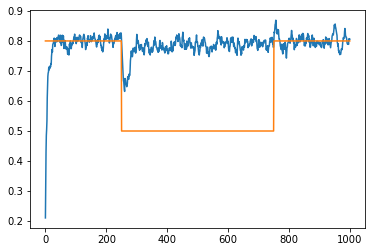

In [135]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [136]:
activations = [activation.numpy() for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [137]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [138]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [139]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

In [140]:
subspaces = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces.append(Xd)

1
2
3
4
5
6
7
8


Text(0, 0.5, '0-1 normalized metric')

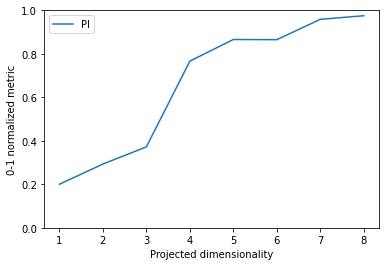

In [141]:
plt.plot(ds, np.asarray(pi)/max_pi.numpy(), label='PI')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Plotting 1D Projection')

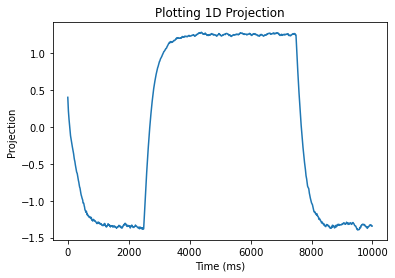

In [142]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Projection')
plt.title('Plotting 1D Projection')

Subspace angles for each projection (1D - 10D)

Plotting scatter of all subspace angles for each pair

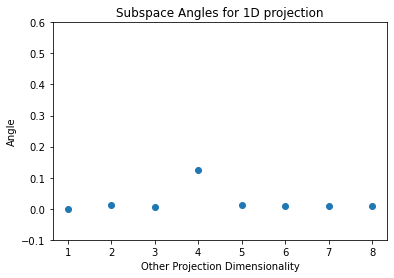

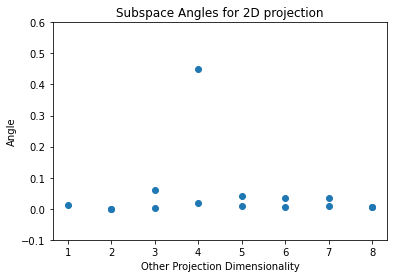

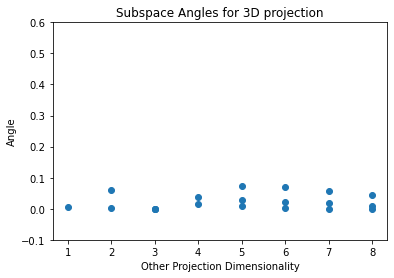

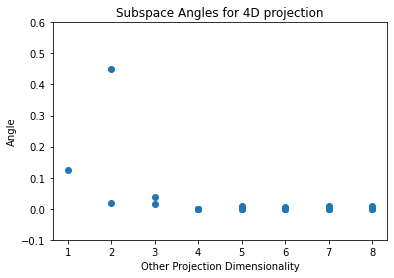

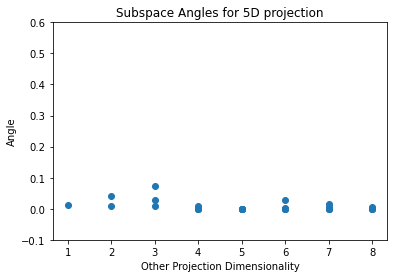

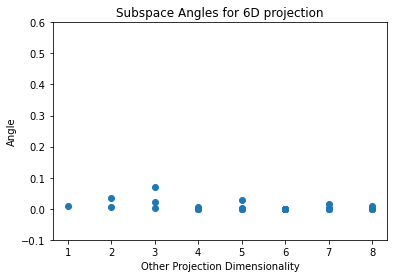

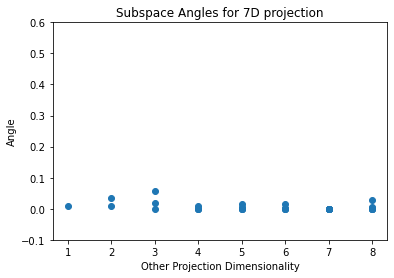

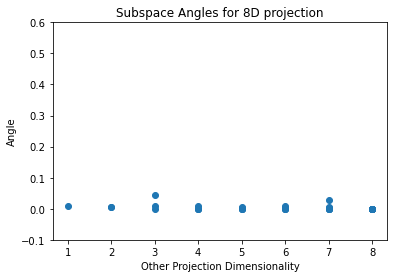

In [143]:
for d in ds:
    x = []
    y = []
    for tmpDim in ds:
        angls = subspace_angles(subspaces[d-1], subspaces[tmpDim - 1])
        x = np.append(x, tmpDim * np.ones(angls.size))
        y = np.append(y, angls)
    fig, ax = plt.subplots(1,1)
    ax.set_title('Subspace Angles for ' + str(d) + 'D projection')
    ax.set_xlabel('Other Projection Dimensionality')
    ax.set_ylabel('Angle')
    ax.scatter(x, y)
    plt.ylim(-0.1, 0.6)
    plt.show()

Subspaces are nested

Plot of DCA1 vs DCA2 for 2D projection

Accounts for 0.29315443362878313 of the predictive information


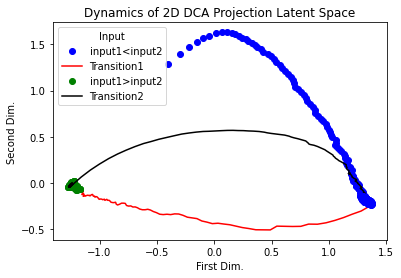

In [144]:
print('Accounts for ' + str((np.asarray(pi)/max_pi.numpy())[1]) + ' of the predictive information')
transition_times = [0, 250, 750, 1000]
change = 100

t = [transition_times[0],transition_times[1] - change , transition_times[1] + change
     , transition_times[2] - change, transition_times[2] + change, transition_times[3]]
plt.plot(subspaces[1][t[0]:t[1], 0], subspaces[1][t[0]:t[1], 1], 'bo', label = 'input1<input2')
plt.plot(subspaces[1][t[1]:t[2], 0], subspaces[1][t[1]:t[2], 1], 'r-', label = 'Transition1')
plt.plot(subspaces[1][t[2]:t[3], 0], subspaces[1][t[2]:t[3], 1], 'go', label = 'input1>input2')
plt.plot(subspaces[1][t[3]:t[4], 0], subspaces[1][t[3]:t[4], 1], 'k-', label = 'Transition2')
plt.plot(subspaces[1][t[4]:t[5], 0], subspaces[1][t[4]:t[5], 1], 'bo') #input1<input2

plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')
plt.legend(title = 'Input')

Projecting dynamics onto 3D subspace

Text(0.5, 0, 'Third Dim.')

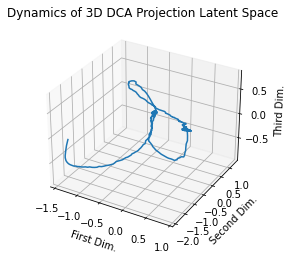

In [145]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(subspaces[2][:, 0], subspaces[2][:, 1], zs=subspaces[2][:, 2])

plt.title('Dynamics of 3D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')
ax.set_zlabel('Third Dim.')
#plt.legend(title = 'Input')

Plotting Network output using same time intervals and legend as above

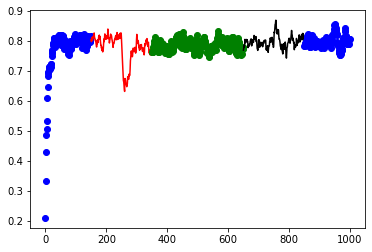

In [146]:
fig, ax = plt.subplots()
plt.plot(range(len(outputs))[t[0]:t[1]], outputs[t[0]:t[1]], 'bo')
plt.plot(range(len(outputs))[t[1]:t[2]], outputs[t[1]:t[2]], 'r-')
plt.plot(range(len(outputs))[t[2]:t[3]], outputs[t[2]:t[3]], 'go')
plt.plot(range(len(outputs))[t[3]:t[4]], outputs[t[3]:t[4]], 'k-')
plt.plot(range(len(outputs))[t[4]:t[5]], outputs[t[4]:t[5]], 'bo')
plt.show()

Observations: Trajectory transitions between two stationary states in latent space. The latent space projection shows the transition start prior to the network output changing. The latent space and output transition trajectory has little noise and the noise is only seen when the network is in its steady-state

Plot of PCA1 vs PCA2 for Dynamics

In [147]:
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.84546745 0.09338223]


Text(0, 0.5, 'Second Dim.')

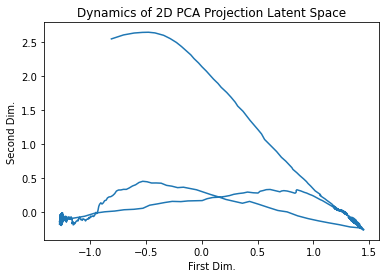

In [148]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

### Running DCA on the different attractors and comparing

**input1<input2**

In [149]:
network.reset_activations()
time=10000

val1 = 1.2
val2 = 1.3

def input1(time):
    return val1 + np.random.normal(0, .01)
def input2(time):
    return val2 + np.random.normal(0, .01)

def target_func(time):
    return 0.5 * (val1 > val2) + .8 * (val2 > val1)
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 298.72it/s]


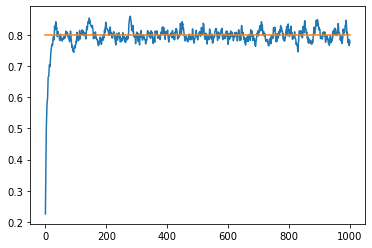

In [150]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [151]:
activations = [activation.numpy() for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [152]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [153]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [154]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction


In [155]:
subspaces_low_inp = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces_low_inp.append(Xd)

1
2
3
4
5
6
7
8


Text(0, 0.5, '0-1 normalized metric')

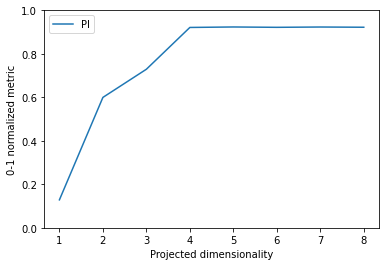

In [156]:
plt.plot(ds, np.asarray(pi)/max_pi.numpy(), label='PI')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Plotting 1D projection')

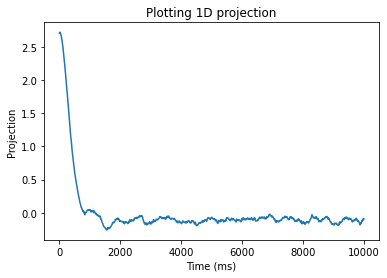

In [157]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Projection')
plt.title('Plotting 1D projection')

Plot of DCA1 vs DCA2 for 2D Projection

Text(0, 0.5, 'Second Dim.')

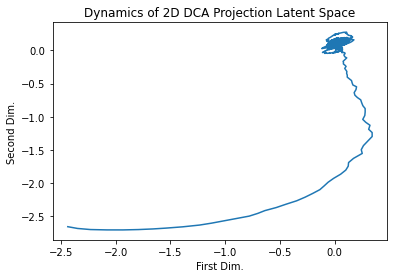

In [158]:
plt.plot(subspaces_low_inp[1][:, 0], subspaces_low_inp[1][:, 1])
plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

Plot of PCA1 vs PCA2 for Dynamics

In [159]:
X_low_inp = X
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.8541233  0.09642027]


Text(0, 0.5, 'Second Dim.')

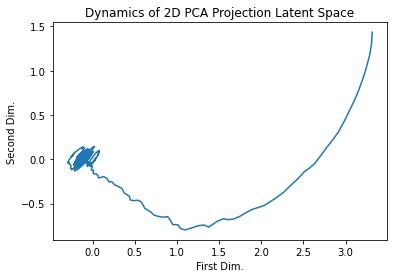

In [160]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

**Input1>Input2**

In [161]:
network.reset_activations()
time=10000

val1 = 0.5
val2 = 0.4

def input1(time):
    return val1 + np.random.normal(0, .01)
def input2(time):
    return val2 + np.random.normal(0, .01)

def target_func(time):
    return 0.5 * (val1 > val2) + .8 * (val2 > val1)
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 524.04it/s]


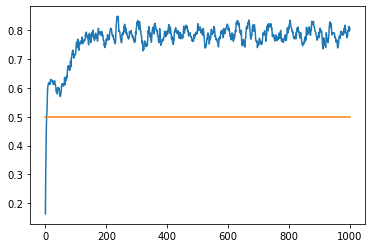

In [162]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [163]:
activations = [activation.numpy() for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [164]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [165]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [166]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

In [167]:
subspaces_high_inp = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces_high_inp.append(Xd)

1
2
3
4
5
6
7
8


Text(0, 0.5, '0-1 normalized metric')

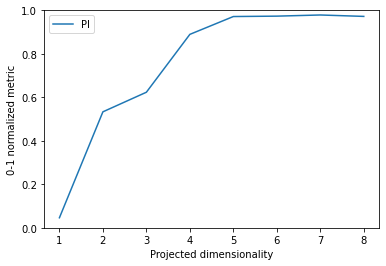

In [168]:
plt.plot(ds, np.asarray(pi)/max_pi.numpy(), label='PI')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Fitting 1D projection to Output')

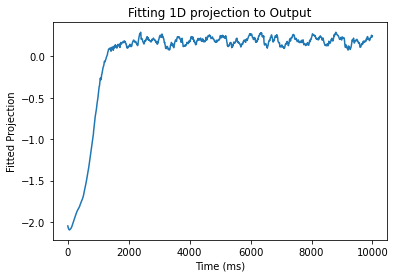

In [169]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Fitted Projection')
plt.title('Fitting 1D projection to Output')

Plot of DCA1 vs DCA2 of 2D Projection

Text(0, 0.5, 'Second Dim.')

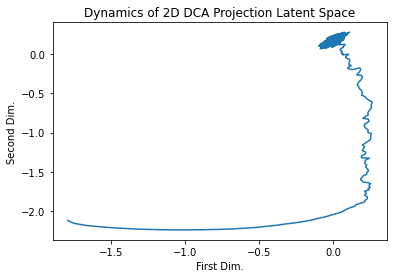

In [170]:
plt.plot(subspaces_high_inp[1][:, 0], subspaces_high_inp[1][:, 1])
plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

Plot of PCA1 vs PCA2 for Dynamics

In [171]:
X_high_inp = X
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.8526716 0.0902694]


Text(0, 0.5, 'Second Dim.')

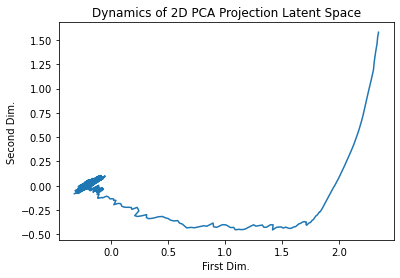

In [172]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

**Plotting Subspace Angles Between Low Input and High Input**

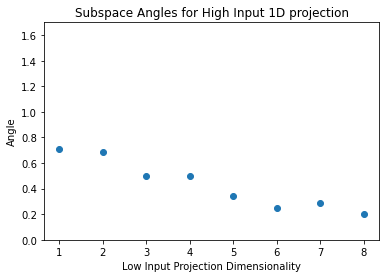

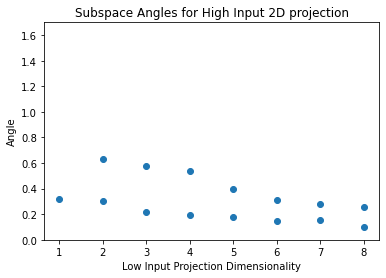

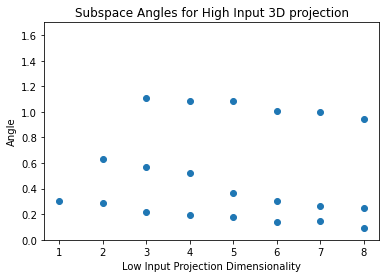

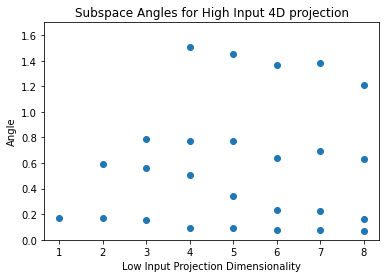

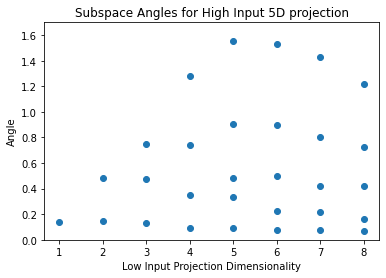

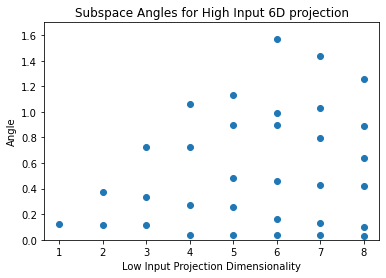

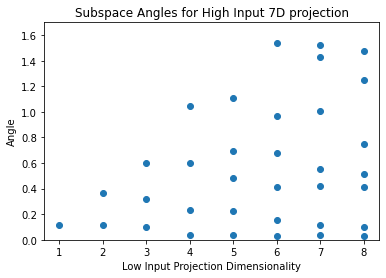

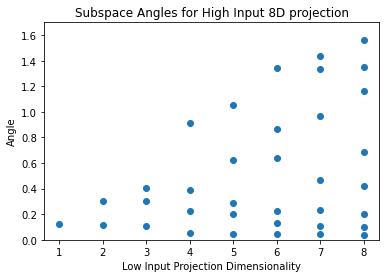

In [173]:
for d in ds:
    x = []
    y = []
    for tmpDim in ds:
        angls = subspace_angles(subspaces_high_inp[d-1], subspaces_low_inp[tmpDim - 1])
        x = np.append(x, tmpDim * np.ones(angls.size))
        y = np.append(y, angls)
    fig, ax = plt.subplots(1,1)
    ax.set_title('Subspace Angles for High Input ' + str(d) + 'D projection')
    ax.set_xlabel('Low Input Projection Dimensionality')
    ax.set_ylabel('Angle')
    ax.scatter(x, y)
    plt.ylim(0, 1.7)
    plt.show()

Plotting subspace angles for low and high input, same dimensionality

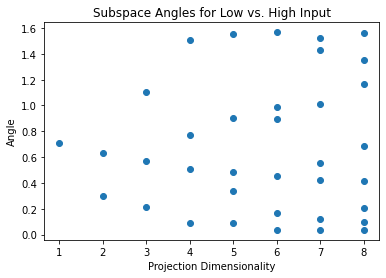

In [174]:
x = []
y = []
for d in ds:
    angls = subspace_angles(subspaces_high_inp[d-1], subspaces_low_inp[d - 1])
    x = np.append(x, d * np.ones(angls.size))
    y = np.append(y, angls)
fig, ax = plt.subplots(1,1)
ax.set_title('Subspace Angles for Low vs. High Input')
ax.set_xlabel('Projection Dimensionality')
ax.set_ylabel('Angle')
ax.scatter(x, y)
plt.show()

Orthogonal components begin to appear at 4D. The middle components begin to appear first at 2,3D. They kind of cluster at 8D.

Plot of 1D projections from each attractor against each other

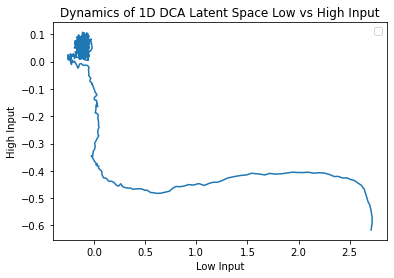

In [175]:
plt.plot(subspaces_low_inp[0][:, 0], subspaces_high_inp[0][:, 0])
plt.title('Dynamics of 1D DCA Latent Space Low vs High Input')
plt.xlabel('Low Input')
plt.ylabel('High Input')
plt.legend()

Plot of first PCA component of each attractor

In [176]:
pca_low = PCA(n_components=1)
pca_low.fit(X_low_inp)
print('The explained variance is:' + str(pca_low.explained_variance_ratio_))
X_pca_low = pca.transform(X_low_inp)

pca_high = PCA(n_components=1)
pca_high.fit(X_high_inp)
print('The explained variance is:' + str(pca_high.explained_variance_ratio_))
X_pca_high = pca.transform(X_high_inp)

The explained variance is:[0.8541235]
The explained variance is:[0.8526716]


Text(0, 0.5, 'High Input')

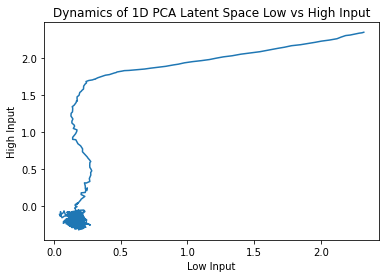

In [177]:
plt.plot(X_pca_low[:, 0], X_pca_high[:, 0])
plt.title('Dynamics of 1D PCA Latent Space Low vs High Input')
plt.xlabel('Low Input')
plt.ylabel('High Input')

PCA curves capture more noise. 

### Low Difference Same Location

In [251]:
network.reset_activations()
time=10000
switch_time=[2500, 7500]

val1 = 1.5
val2 = 1.6
val3 = 1.6
val4 = 1.5

def input1(time):
    if time < switch_time[0]:
        return val1 + np.random.normal(0, .01)
    elif time >= switch_time[0] and time < switch_time[1]:
        return val3 + np.random.normal(0, .01)
    else:
        return val1 + np.random.normal(0, .01)
def input2(time):
    if time < switch_time[0]:
        return val2 + np.random.normal(0, .01)
    elif time >= switch_time[0] and time < switch_time[1]:
        return val4 + np.random.normal(0, .01)
    else:
        return val2 + np.random.normal(0, .01)

def target_func(time):
    #running for 15 seconds = 15000ms
    if time < switch_time[0]:
        return 0.5 * (val1 > val2) + .8 * (val2 > val1)
    elif time>= switch_time[0] and time < switch_time[1]:
        return 0.5 * (val3 > val4) + .8 * (val4 > val3)
    else:
        return 0.5 * (val1 > val2) + .8 * (val2 > val1)
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 656.31it/s]


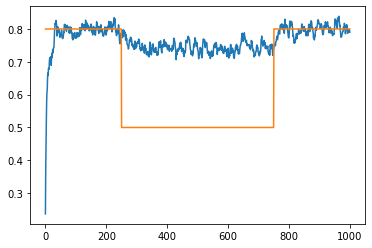

In [252]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

When Network is unsure, tends to lean towards staying the same (only if input2>input1, otherwise changes quickly) but sometimes slowly changes to correct value.

In [206]:
activations = [activation.numpy() for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [207]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [208]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [209]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

In [211]:
subspaces = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces.append(Xd)

1
2
3
4
5
6
7
8


Text(0, 0.5, '0-1 normalized metric')

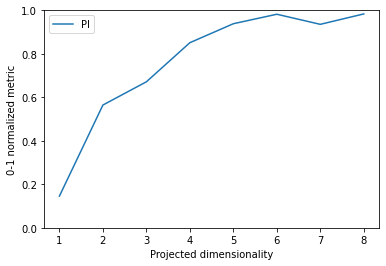

In [212]:
plt.plot(ds, np.asarray(pi)/max_pi.numpy(), label='PI')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Plotting 1D Projection')

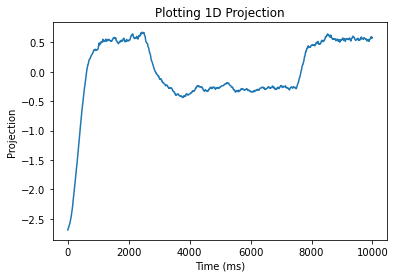

In [213]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Projection')
plt.title('Plotting 1D Projection')

Subspace angles for each projection (1D - 10D)

Plotting scatter of all subspace angles for each pair

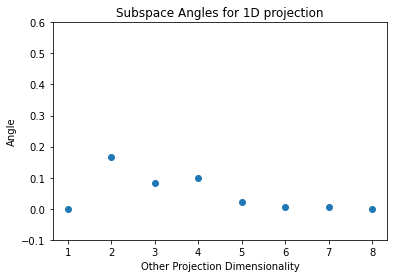

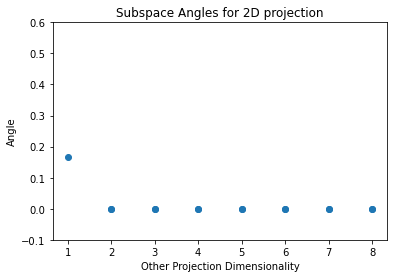

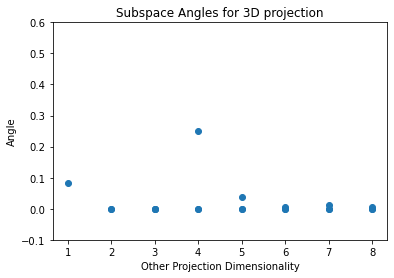

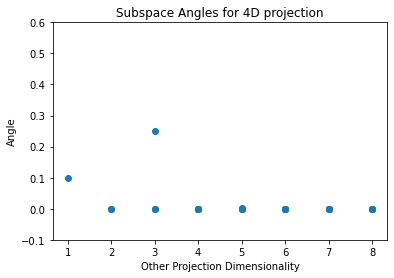

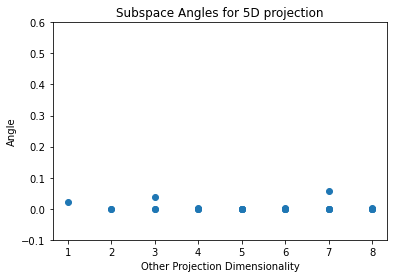

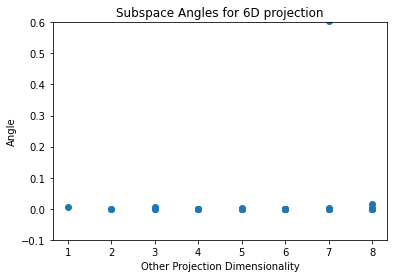

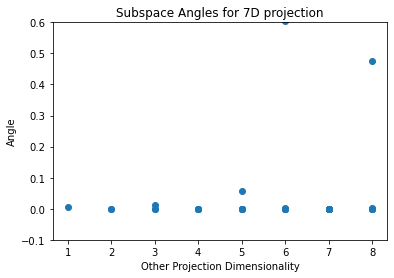

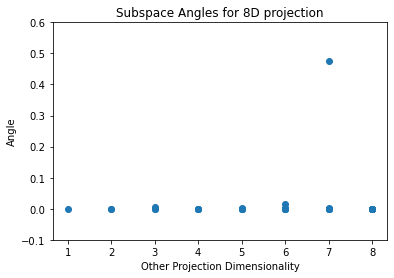

In [214]:
for d in ds:
    x = []
    y = []
    for tmpDim in ds:
        angls = subspace_angles(subspaces[d-1], subspaces[tmpDim - 1])
        x = np.append(x, tmpDim * np.ones(angls.size))
        y = np.append(y, angls)
    fig, ax = plt.subplots(1,1)
    ax.set_title('Subspace Angles for ' + str(d) + 'D projection')
    ax.set_xlabel('Other Projection Dimensionality')
    ax.set_ylabel('Angle')
    ax.scatter(x, y)
    plt.ylim(-0.1, 0.6)
    plt.show()

Subspaces are nested

Plot of DCA1 vs DCA2 for 2D projection

Accounts for 0.5645441485494279 of the predictive information


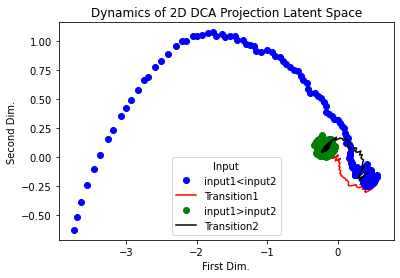

In [215]:
print('Accounts for ' + str((np.asarray(pi)/max_pi.numpy())[1]) + ' of the predictive information')
transition_times = [0, 250, 750, 1000]
change = 100

t = [transition_times[0],transition_times[1] - change , transition_times[1] + change
     , transition_times[2] - change, transition_times[2] + change, transition_times[3]]
plt.plot(subspaces[1][t[0]:t[1], 0], subspaces[1][t[0]:t[1], 1], 'bo', label = 'input1<input2')
plt.plot(subspaces[1][t[1]:t[2], 0], subspaces[1][t[1]:t[2], 1], 'r-', label = 'Transition1')
plt.plot(subspaces[1][t[2]:t[3], 0], subspaces[1][t[2]:t[3], 1], 'go', label = 'input1>input2')
plt.plot(subspaces[1][t[3]:t[4], 0], subspaces[1][t[3]:t[4], 1], 'k-', label = 'Transition2')
plt.plot(subspaces[1][t[4]:t[5], 0], subspaces[1][t[4]:t[5], 1], 'bo') #input1<input2

plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')
plt.legend(title = 'Input')

Projecting dynamics onto 3D subspace

Text(0.5, 0, 'Third Dim.')

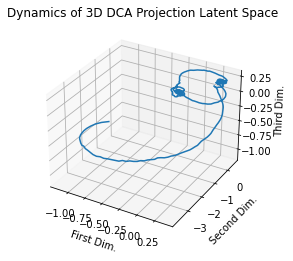

In [216]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(subspaces[2][:, 0], subspaces[2][:, 1], zs=subspaces[2][:, 2])

plt.title('Dynamics of 3D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')
ax.set_zlabel('Third Dim.')
#plt.legend(title = 'Input')

Plotting Network output using same time intervals and legend as above

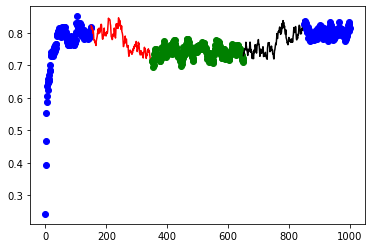

In [217]:
fig, ax = plt.subplots()
plt.plot(range(len(outputs))[t[0]:t[1]], outputs[t[0]:t[1]], 'bo')
plt.plot(range(len(outputs))[t[1]:t[2]], outputs[t[1]:t[2]], 'r-')
plt.plot(range(len(outputs))[t[2]:t[3]], outputs[t[2]:t[3]], 'go')
plt.plot(range(len(outputs))[t[3]:t[4]], outputs[t[3]:t[4]], 'k-')
plt.plot(range(len(outputs))[t[4]:t[5]], outputs[t[4]:t[5]], 'bo')
plt.show()

Observations: Trajectory transitions between two stationary states in latent space. The latent space projection shows the transition start prior to the network output changing. The latent space and output transition trajectory has little noise and the noise is only seen when the network is in its steady-state

Plot of PCA1 vs PCA2 for Dynamics

In [218]:
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.77154833 0.12836987]


Text(0, 0.5, 'Second Dim.')

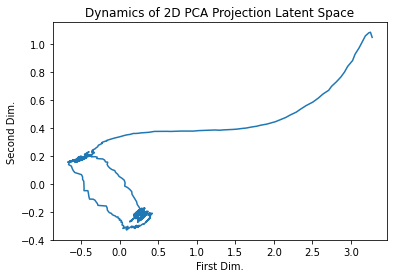

In [219]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

### Running DCA on the different attractors and comparing

**input1<input2**

In [220]:
network.reset_activations()
time=10000

val1 = 1.5
val2 = 1.6

def input1(time):
    return val1 + np.random.normal(0, .01)
def input2(time):
    return val2 + np.random.normal(0, .01)

def target_func(time):
    return 0.5 * (val1 > val2) + .8 * (val2 > val1)
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 546.29it/s]


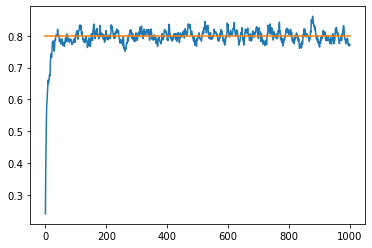

In [221]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [222]:
activations = [activation.numpy() for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [223]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [224]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [225]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction


In [226]:
subspaces_low_inp = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces_low_inp.append(Xd)

1
2
3
4
5
6
7
8


Text(0, 0.5, '0-1 normalized metric')

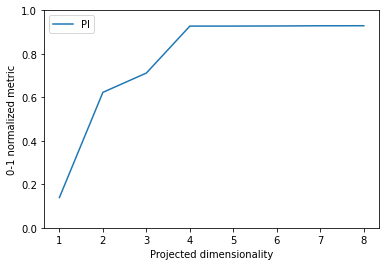

In [227]:
plt.plot(ds, np.asarray(pi)/max_pi.numpy(), label='PI')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Plotting 1D projection')

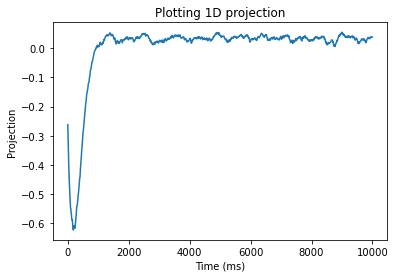

In [228]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Projection')
plt.title('Plotting 1D projection')

Plot of DCA1 vs DCA2 for 2D Projection

Text(0, 0.5, 'Second Dim.')

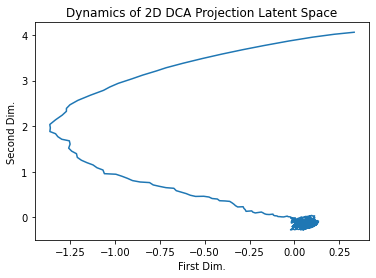

In [229]:
plt.plot(subspaces_low_inp[1][:, 0], subspaces_low_inp[1][:, 1])
plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

Plot of PCA1 vs PCA2 for Dynamics

In [230]:
X_low_inp = X
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.8840179  0.07894062]


Text(0, 0.5, 'Second Dim.')

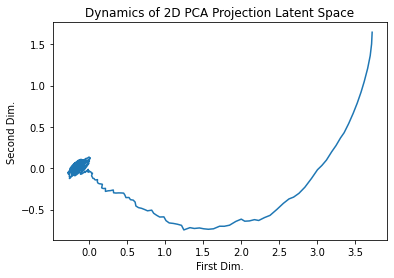

In [231]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

**Input1>Input2**

In [232]:
network.reset_activations()
time=10000

val1 = 1.6
val2 = 1.5

def input1(time):
    return val1 + np.random.normal(0, .01)
def input2(time):
    return val2 + np.random.normal(0, .01)

def target_func(time):
    return 0.5 * (val1 > val2) + .8 * (val2 > val1)
input_funcs[2] = input1
input_funcs[3] = input2
inputs = network.convert(time, input_funcs)

outputs, activations = network.simulate(time, inputs, input_weight_matrix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 389.44it/s]


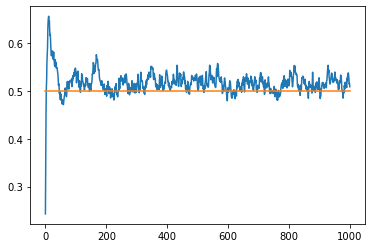

In [233]:
outputs = tf.transpose(outputs).numpy()[0]

fig, ax = plt.subplots()
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), [target_func(t * timestep) for t in range(len(outputs))])
plt.show()

In [234]:
activations = [activation.numpy() for activation in activations]
activations = np.asarray(activations)

Running DCA on inputs

In [235]:
max_dim = 8
ds = np.arange(1, max_dim+1)

In [236]:
X = activations
Y = np.reshape(outputs, (outputs.size, 1))

In [237]:
pi = np.zeros(ds.size) #Predictive Information
dca_scores = np.zeros(ds.size)
dca_model = DCA(T=10, d=128)
dca_model.estimate_data_statistics(X) # only need to estimate this once
max_pi = dca_model.score() # PI of data with no dimensionality reduction

In [238]:
subspaces_high_inp = []
for ii, d in enumerate(ds):
    print(d)
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    subspaces_high_inp.append(Xd)

1
2
3
4
5
6
7
8


Text(0, 0.5, '0-1 normalized metric')

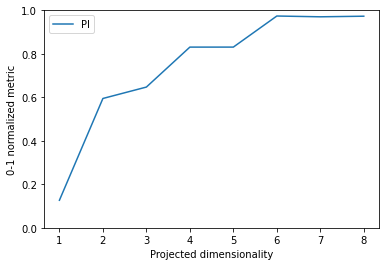

In [239]:
plt.plot(ds, np.asarray(pi)/max_pi.numpy(), label='PI')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.xlabel('Projected dimensionality')
plt.ylabel('0-1 normalized metric')

Plotting one-dimensional projection of neural activity

Text(0.5, 1.0, 'Fitting 1D projection to Output')

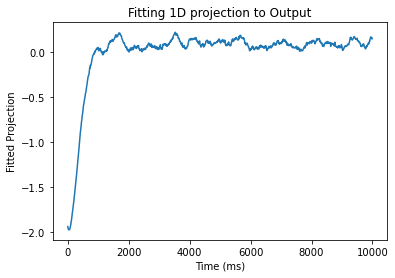

In [240]:
d = 1
dca_model.fit_projection(d=d)
pi[ii] = dca_model.score()
Xd = dca_model.transform(X)
plt.plot(np.arange(0, time, 10), Xd[:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Fitted Projection')
plt.title('Fitting 1D projection to Output')

Plot of DCA1 vs DCA2 of 2D Projection

Text(0, 0.5, 'Second Dim.')

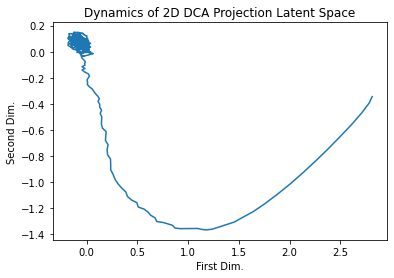

In [241]:
plt.plot(subspaces_high_inp[1][:, 0], subspaces_high_inp[1][:, 1])
plt.title('Dynamics of 2D DCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

Plot of PCA1 vs PCA2 for Dynamics

In [242]:
X_high_inp = X
pca = PCA(n_components=2)
pca.fit(X)
print('The explained variance is:' + str(pca.explained_variance_ratio_))
X_pca = pca.transform(X)

The explained variance is:[0.72769994 0.12603453]


Text(0, 0.5, 'Second Dim.')

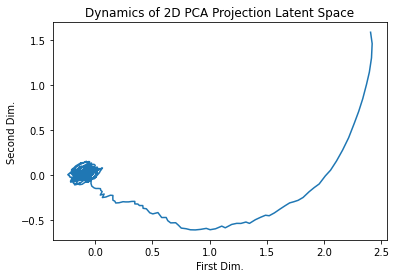

In [243]:
plt.plot(X_pca[:, 0], X_pca[:, 1])
plt.title('Dynamics of 2D PCA Projection Latent Space')
plt.xlabel('First Dim.')
plt.ylabel('Second Dim.')

**Plotting Subspace Angles Between Low Input and High Input**

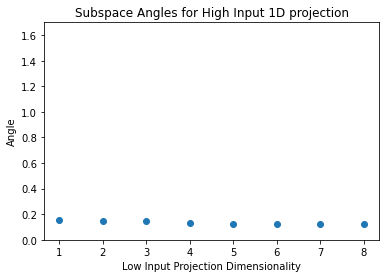

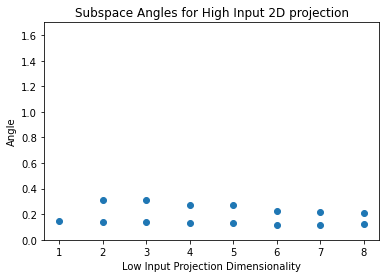

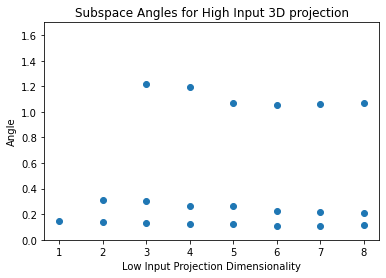

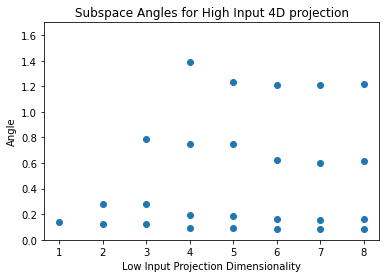

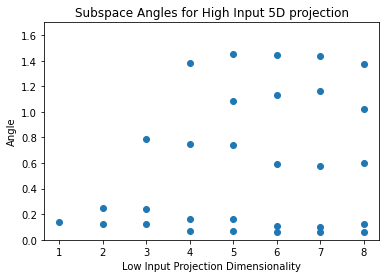

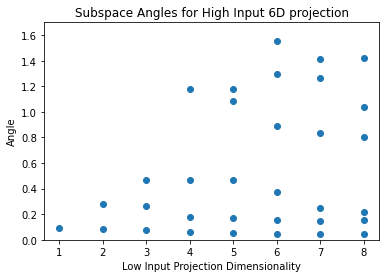

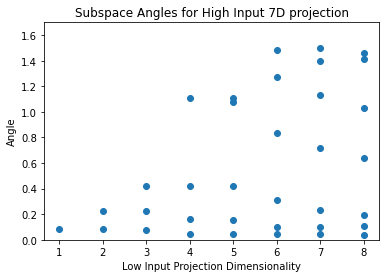

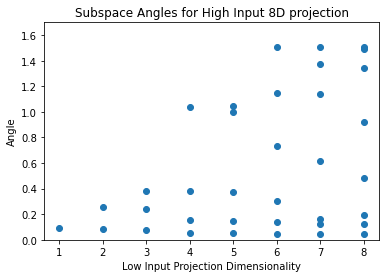

In [244]:
for d in ds:
    x = []
    y = []
    for tmpDim in ds:
        angls = subspace_angles(subspaces_high_inp[d-1], subspaces_low_inp[tmpDim - 1])
        x = np.append(x, tmpDim * np.ones(angls.size))
        y = np.append(y, angls)
    fig, ax = plt.subplots(1,1)
    ax.set_title('Subspace Angles for High Input ' + str(d) + 'D projection')
    ax.set_xlabel('Low Input Projection Dimensionality')
    ax.set_ylabel('Angle')
    ax.scatter(x, y)
    plt.ylim(0, 1.7)
    plt.show()

Plotting subspace angles for low and high input, same dimensionality

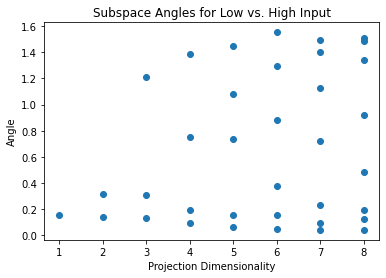

In [245]:
x = []
y = []
for d in ds:
    angls = subspace_angles(subspaces_high_inp[d-1], subspaces_low_inp[d - 1])
    x = np.append(x, d * np.ones(angls.size))
    y = np.append(y, angls)
fig, ax = plt.subplots(1,1)
ax.set_title('Subspace Angles for Low vs. High Input')
ax.set_xlabel('Projection Dimensionality')
ax.set_ylabel('Angle')
ax.scatter(x, y)
plt.show()

Orthogonal components begin to appear at 3D. Graph is spread out

Plot of 1D projections from each attractor against each other

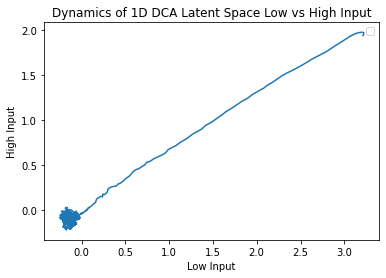

In [246]:
plt.plot(subspaces_low_inp[0][:, 0], subspaces_high_inp[0][:, 0])
plt.title('Dynamics of 1D DCA Latent Space Low vs High Input')
plt.xlabel('Low Input')
plt.ylabel('High Input')
plt.legend()

Plot of first PCA component of each attractor

In [247]:
pca_low = PCA(n_components=1)
pca_low.fit(X_low_inp)
print('The explained variance is:' + str(pca_low.explained_variance_ratio_))
X_pca_low = pca.transform(X_low_inp)

pca_high = PCA(n_components=1)
pca_high.fit(X_high_inp)
print('The explained variance is:' + str(pca_high.explained_variance_ratio_))
X_pca_high = pca.transform(X_high_inp)

The explained variance is:[0.8840179]
The explained variance is:[0.7277001]


Text(0, 0.5, 'High Input')

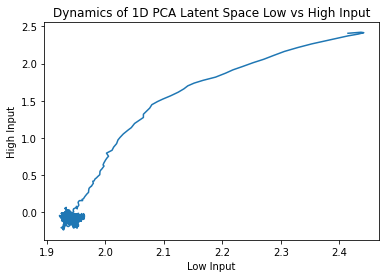

In [248]:
plt.plot(X_pca_low[:, 0], X_pca_high[:, 0])
plt.title('Dynamics of 1D PCA Latent Space Low vs High Input')
plt.xlabel('Low Input')
plt.ylabel('High Input')

PCA curves capture more noise. 